# Data Preprocessing

## Importing the libraries

In [8]:
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import csv
import os
import requests
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')

## Load the dataset

In [9]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_origin = pd.read_csv('games-regression-dataset.csv', parse_dates=['Original Release Date' , 'Current Version Release Date'], date_parser=dateparse)

## Download the icons

In [ ]:
# Convert to string
df_origin['Icon URL'] = df_origin['Icon URL'].astype(str)

import requests
import os
import shutil


def download_image(url, filename):
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)


# Create a folder to store the images
if not os.path.exists('icons'):
    os.makedirs('icons')

# Download the images
for i, row in df_origin.iterrows():
    download_image(row['Icon URL'], f'icons/{i}.png')

In [10]:
# Replace the URL with the icon filename which is the index of the row
df_origin['Icon URL'] = df_origin.apply(lambda row : f'icons/{row.name}.png', axis=1)

## Sentiment Analysis for reviews

### web scraping on Reviews URLs

In [ ]:
df = pd.DataFrame(columns = ["ID","Reviews"])
# Read CSV file
# with open('games-regression-dataset.csv', newline='') as csvfile:
with open('games-regression-dataset.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip header row
    for row in reader:
        url = row[0]  # URL is in first column
        filename = 'Reviews/'+os.path.basename(url)  # Extract filename from URL
        url +=  "?see-all=reviews"
        response = requests.get(url)
        if response.status_code == 200:  # Check if request was successful
            soup = BeautifulSoup(response.text, 'html.parser')
            blocks = soup.findAll("blockquote")
            review_list = []
            for blockquote in blocks:
                review = blockquote.find('p').text
                review_list.append(review)
            if len(review_list)!=0:
                filename = re.sub(r'[^\d]+', '', filename)
                new_row = {'ID': filename,"Reviews": review_list}
                df = df._append(new_row, ignore_index=True)
df.to_csv('Reviews.csv', index=False)


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Splitting reviews

In [5]:
data = pd.read_csv('Reviews.csv')
counter=0

for i in range (len(data)):
    data.at[i, 'Reviews'] = data.at[i, "Reviews"].split("',")
    data.at[i,"ID"] =data.at[i,"ID"]
data = data.explode('Reviews')
data

FileNotFoundError: [Errno 2] No such file or directory: 'Reviews.csv'

### Preprocessing reviews


In [ ]:

# Convert text to lowercase
data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())

# Replace newline characters with an empty string
data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\n', ' ', x))

# Remove black squares
data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\u25a0', '', x))

# Remove special characters and punctuations
data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

# Remove numbers
data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.split() if not any(char.isdigit() for char in word)]))

# Remove extra whitespaces
data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))

# Remove stop words
data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]))

# Remove empty strings
data = data[data['Reviews'].apply(lambda x: len(x)>0)]

data.at[0,'Reviews']

### Vader-model

In [ ]:
sia_reviews = SentimentIntensityAnalyzer()
# pickle.dump(sia_reviews, open('encoders/sia_reviews.pkl', 'wb'))
data['Reviews'] = data['Reviews'].apply(lambda x: dict(sia_reviews.polarity_scores(x))['compound'])


### Get compound average & Group by id


In [ ]:
data = data.groupby('ID')['Reviews'].apply(list).reset_index()

In [ ]:
# Get the lowest, highest and average Reviews
data['lowest_review'] = data['Reviews'].apply(lambda x: min(x) if len(x) > 0 else 0)
data['highest_review'] = data['Reviews'].apply(lambda x: max(x) if len(x) > 0 else 0)
data['average_review'] = data['Reviews'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
data = data.drop(['Reviews'],axis=1)

In [ ]:
data.to_csv('reviews_results.csv', index=False)

In [11]:
sentiment = pd.read_csv('reviews_results.csv')
## Merge The Sentiment with ba2i el table
df_origin = df_origin.merge(sentiment, on='ID', how='left')
## Drop nulls of sentiment
df_origin = df_origin.dropna(subset=['lowest_review','highest_review','average_review'])
df_origin.head()


,URL,ID,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,...,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Average User Rating,lowest_review,highest_review,average_review
0,https://apps.apple.com/us/app/heir-of-light/id...,1264483706,HEIR OF LIGHT,Dark Fantasy RPG,icons/0.png,982,0.00,"29.99, 19.99, 9.99, 29.99, 29.99, 8.99, 4.99, ...","A Dark Fantasy, Collectible RPG\n\nDarkness ha...",GAMEVIL Inc.,...,"EN, FR, DE, JA, KO, ZH, ES, TH, ZH, VI",894489600,Games,"Games, Role Playing, Strategy",2018-03-06,2019-07-31,4.0,-0.7417,0.9953,0.791020
1,https://apps.apple.com/us/app/endgame-eurasia/...,607705356,Endgame:Eurasia,NaN,icons/1.png,19,0.00,NaN,"""This interactive experience is an exploration...",Auroch Digital Ltd,...,EN,116407296,Games,"Games, Simulation, Strategy, News",2013-03-21,2017-06-28,3.5,-0.9246,0.9906,0.475180
8,https://apps.apple.com/us/app/airport-madness-...,393575110,Airport Madness Challenge,NaN,icons/8.png,1815,0.99,"0.99, 2.99, 1.99, 3.99, 4.99, 1.99, 9.99, 9.99...","Earn experience and unlock new, awesome, FREE ...",Fluik,...,EN,63327232,Games,"Games, Simulation, Entertainment, Strategy",2010-10-15,2018-04-24,4.0,-0.8402,0.8981,0.341611
10,https://apps.apple.com/us/app/trumps-small-loa...,1121788355,Trumps Small Loan: Make More Money,NaN,icons/10.png,6,0.00,NaN,Trump gives a small loan of $1.00! \nKeep swip...,Adam Irvine,...,EN,11390976,Games,"Games, Puzzle, Strategy, Entertainment",2016-06-09,2016-06-09,2.5,0.0000,0.6597,0.271500
11,https://apps.apple.com/us/app/ultimate-battle-...,1229445376,Ultimate Battle Simulator,NaN,icons/11.png,46,0.00,NaN,Ultimate battle simulator ( UBS ) its physics...,Filip Rudzinski,...,EN,251660288,Games,"Games, Action, Strategy",2017-04-24,2017-05-30,3.5,-0.6597,0.9423,0.323970


## Data Splitting

In [12]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df_origin, test_size=0.2, random_state=42)
df_test.to_csv('df_test.csv', index=False)

In [13]:
df.shape

(2195, 21)

## Dropping unnecessary columns

In [14]:
# drop Primary Genre
df.drop(['Primary Genre','ID', 'URL'], axis=1, inplace=True)

In [15]:
df

,Name,Subtitle,Icon URL,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Genres,Original Release Date,Current Version Release Date,Average User Rating,lowest_review,highest_review,average_review
4330,Brass,NaN,icons/4330.png,205,5.99,NaN,"""It\u2019s wonderful"" - 5/5 from Pocket Tactic...",Cublo Sp. z o.o.,4+,"EN, DE, PL",298156032,"Games, Board, Entertainment, Strategy",2015-11-12,2019-05-31,4.5,0.8655,0.9754,0.913462
2692,Scythe score,Score counter for Scythe game,icons/2692.png,9,0.00,NaN,This is a companion app for the Scythe boardga...,Jane Idelson,4+,EN,29981696,"Games, Entertainment, Strategy",2017-10-18,2018-03-02,3.5,0.0000,0.8456,0.470967
4248,Montessori Handwriting tutor,Zaner Boser and Dnealian,icons/4248.png,12,1.99,NaN,Montesori Dnealian Handwriting tutor is the pe...,Nathalie Palma,4+,EN,223058944,"Education, Strategy, Games, Family",2012-02-11,2018-03-27,4.0,-0.4215,0.9915,0.550650
3032,Army Defence Free,NaN,icons/3032.png,6,0.00,0.99,"""Army Defence Free a new tower defence game wi...",Amr Labib,4+,EN,49547264,"Games, Strategy",2013-12-20,2016-12-02,3.0,0.1779,0.8689,0.511225
3553,Backgammon King,NaN,icons/3553.png,59,0.00,NaN,Backgammon is the oldest board game played by ...,MOBIRIX,4+,"EN, FR, DE, JA, KO, PT, RU, ZH, ES, ZH",24093696,"Games, Strategy, Board, Entertainment",2015-03-17,2018-12-17,4.0,-0.4472,0.9875,0.537111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077,Battle Islands,Epic Combat Strategy!,icons/3077.png,6906,0.00,"4.99, 1.99, 9.99, 24.99, 7.99, 49.99, 99.99, 2...","""Battle for supremacy in this epic WWII combat...","505 Games (US), Inc.",12+,"EN, FR, DE, IT, PT, RU, ES, TR",224664576,"Games, Strategy, Entertainment, Simulation",2013-12-12,2018-09-04,4.0,-0.9791,0.9524,0.341878
2060,Gold Rush! Anniversary HD,NaN,icons/2060.png,8,1.99,NaN,"In 1988, Rush appeared with Gold! in one of th...",Sunlight Games GmbH,4+,EN,2796224512,"Games, Entertainment, Adventure, Strategy",2015-03-04,2018-04-28,2.5,-0.5240,0.9304,0.609450
2139,Hunter Weapons Add-On for Minecraft PE: MCPE,NaN,icons/2139.png,52,0.00,0.99,This addon changes the behavior and textures f...,Nadeem Mughal,12+,EN,17515520,"Reference, Strategy, Games",2016-12-22,2017-01-10,2.5,-0.6705,0.7284,0.186789
2436,Defend Your Turf: Arcade Street Fight,NaN,icons/2436.png,47,0.00,2.99,"""In a small town somewhere on earth, a bunch o...",Stephen Folkes,12+,EN,23917568,"Games, Action, Strategy",2016-09-04,2017-04-19,5.0,0.6124,0.9909,0.859267


## Dates preprocessing

In [16]:
# Convert the datetime to ordinal

df['Original Release Date'] = df['Original Release Date'].apply(lambda x: x.toordinal())
df['Current Version Release Date'] = df['Current Version Release Date'].apply(lambda x: x.toordinal())
df[['Original Release Date', 'Current Version Release Date']].head()

,Original Release Date,Current Version Release Date
4330,735914,737210
2692,736620,736755
4248,734544,736780
3032,735222,736300
3553,735674,737045


In [17]:
# Create a new column with the age of the game
df['game_age'] = df['Current Version Release Date'] - df['Original Release Date']

# Create a new column with the time since the last update
df['last_update'] = datetime.now().toordinal() - df['Current Version Release Date'] 

df[['game_age', 'last_update']].head()

,game_age,last_update
4330,1296,1425
2692,135,1880
4248,2236,1855
3032,1078,2335
3553,1371,1590


## Data Exploration

### General information

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

### Genres

In [ ]:
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

genre_counts = df.explode('Genres').groupby('Genres').size().sort_values(ascending=False)
genre_counts


### Developer

In [ ]:
df['Developer'].value_counts()

In [ ]:
df['Developer'].unique().size

### Languages

In [ ]:
df['Languages'] = df['Languages'].astype(str)

df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

langs_counts = df.explode('Languages').groupby('Languages').size().sort_values(ascending=False)
print(langs_counts[1:30])

In [ ]:
df.hist(figsize=(15, 15))

## Developer preprocessing

In [18]:
# Convert to string
df['Developer'] = df['Developer'].astype(str)
df['Developer'] = df['Developer'].str.replace("'", "").str.strip('[]')

# Replace the developer names with less than 3 games with 'Other'
dev_counts = df['Developer'].value_counts()
other = dev_counts[dev_counts < 3].index
df['Developer'] = df['Developer'].replace(other, 'Other')

dev_df = df[['Developer', 'Average User Rating']].groupby('Developer').mean()

# Save dev_df to be used on the test set
dev_df.to_csv('encoders/dev_df.csv')

# Replace the developer names with the average user rating from dev_df
df['Developer'] = df['Developer'].replace(dev_df.index, dev_df['Average User Rating'])

## Genres preprocessing

### 1. NLP approach

In [ ]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Join the list of genres into a single string
genres = df['Genres'].apply(lambda x: ' '.join(x))

# Create a count Vectorizer and fit it to the genres
count_vec = CountVectorizer()
bow_genres = count_vec.fit_transform(genres)

# Apply principal component analysis to reduce the dimensionality
pca = PCA(n_components=10)
pca_genres = pca.fit_transform(bow_genres.toarray())

# Add the PCA-transformed genres to the original dataframe
for i in range(len(pca_genres[0])):
    df[f'Genre_PCA_{i}'] = pca_genres[:, i]

# Drop the original column
df = df.drop(['Genres'], axis=1)

### 2. Dummy variables approach

In [19]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
other = df['Genres'].explode().value_counts()[df['Genres'].explode().value_counts() < 100].index
df['Genres'] = df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent' for genre in x])

# Get dummy variables for the genres
genres = pd.get_dummies(df['Genres'].apply(pd.Series).stack(), prefix="genre", dummy_na=False).sum(level=0)

# Save the genres dummies to be used on the test set
genres.to_csv('encoders/genres.csv', index=False)

# Add the dummy variables to the original dataframe
df = pd.concat([df, genres], axis=1)

# Drop the original column
df = df.drop(['Genres'], axis=1)

# Fill NaN with 0
genre_cols = [col for col in df.columns if col.startswith('genre')] # get all columns with prefix 'genre'
df[genre_cols] = df[genre_cols].fillna(0) # fill NaN with 0 for selected columns

### 3. Multi-label binarizer

In [ ]:
# Convert the genres column to a list of strings
df['Genres'] = df['Genres'].astype(str)
df['Genres'] = df['Genres'].str.strip('[]').str.replace("'", "").str.split(", ")

# drop Games, Strategy, Entertainment from the Genres column
df['Genres'] = df['Genres'].apply(lambda x: [genre for genre in x if genre not in ['Games', 'Strategy', 'Entertainment']])

# Replace genres with counts less than 100 with 'infrequent' as it would represent a very small percentage of the data (less than 2%)
other = df['Genres'].explode().value_counts()[df['Genres'].explode().value_counts() < 100].index
df['Genres'] = df['Genres'].apply(lambda x: [genre if genre not in other else 'infrequent_genre' for genre in x])

# Instantiate the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to the genres
mlb.fit(df['Genres'])

# Drop nan from the classes
mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

# Save the mlb for later use with the test data
pickle.dump(mlb, open('encoders/mlb_genres.pkl', 'wb'))

# Transform the genres into a one-hot encoded array
genres_mlb = mlb.transform(df['Genres'])

# Create a dataframe from the one-hot encoded array
genres_mlb_df = pd.DataFrame(genres_mlb, columns=mlb.classes_)

# Add the one-hot encoded genres to the original dataframe
df = pd.concat([df, genres_mlb_df], axis=1)

# Drop the original column
df = df.drop(['Genres'], axis=1)

## Languages preprocessing

### 1. NLP approach

In [ ]:
# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Drop the English language from the Languages column
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Join the list of langs into a single string
languages = df['Languages'].apply(lambda x: ' '.join(x))

# Create a count Vectorizer and fit it to the langs
count_vec = CountVectorizer()
bow_languages = count_vec.fit_transform(languages)

# Apply principal component analysis to reduce the dimensionality
pca = PCA(n_components=10)
pca_languages = pca.fit_transform(bow_languages.toarray())

# Add the PCA-transformed langs to the original dataframe
for i in range(len(pca_languages[0])):
    df[f'Languages_PCA_{i}'] = pca_languages[:, i]

# Drop the original column
df = df.drop(['Languages'], axis=1)

print(df.shape)

df.iloc[:, 15:].head()

### 2. Dummy variables approach

In [20]:
# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Create a column with the number of languages supported
df['langs_count'] = df['Languages'].apply(lambda x: len(x))

# Drop the English language from the Languages column (it is the most common language and would dominate the model)
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
other = df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 500].index
df['Languages'] = df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent' for lang in x])

# Get dummy variables for the langs
langs = pd.get_dummies(df['Languages'].apply(pd.Series).stack(), prefix='lang', dummy_na=False).sum(level=0)

langs.to_csv('encoders/langs.csv', index=False)

# Add the dummy variables to the original dataframe
df = pd.concat([df, langs], axis=1)

# Drop the original column
df = df.drop(['Languages'], axis=1)

# Fill NaN with 0
lang_cols = [col for col in df.columns if col.startswith('lang')] # get all columns with prefix 'lang'
df[lang_cols] = df[lang_cols].fillna(0) # fill NaN with 0 for selected columns

### 3. Multi-label binarizer

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the langs column to a list of strings
df['Languages'] = df['Languages'].astype(str)
df['Languages'] = df['Languages'].str.strip('[]').str.replace("'", "").str.split(", ")

# Create a column with the number of languages supported
df['langs_count'] = df['Languages'].apply(lambda x: len(x))

# Drop the English language from the Languages column (it is the most common language and would dominate the model)
df['Languages'] = df['Languages'].apply(lambda x: [lang for lang in x if lang not in ['EN']])

# Replace langs with counts less than 500 with 'infrequent_langs' as it would represent a very small percentage of the data (less than 10%)
other = df['Languages'].explode().value_counts()[df['Languages'].explode().value_counts() < 400].index
df['Languages'] = df['Languages'].apply(lambda x: [lang if lang not in other else 'infrequent_lang' for lang in x])

# Instantiate the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer to the langs
mlb.fit(df['Languages'])

# Drop nan from the classes
mlb.classes_ = np.delete(mlb.classes_, np.where(mlb.classes_ == 'nan'))

# Save the mlb for later use with the test data
pickle.dump(mlb, open('encoders/mlb_langs.pkl', 'wb'))

# Transform the langs into a one-hot encoded array
langs_mlb = mlb.transform(df['Languages'])

# Create a dataframe from the one-hot encoded array
langs_mlb_df = pd.DataFrame(langs_mlb, columns=mlb.classes_)

# Add the encoded langs to the original dataframe
df = pd.concat([df, langs_mlb_df], axis=1)

# Drop the original column
df = df.drop(['Languages'], axis=1)

In [ ]:
df.head()

## In-app Purchases preprocessing

In [21]:
# Free apps might skew the in-app purchases column,
# so we might split the dataset into free and paid apps

df['In-app Purchases'] = df['In-app Purchases'].astype(str)
df['In-app Purchases'] = df['In-app Purchases'].str.strip('[]').str.replace("'", "").str.split(", ")

In [22]:
# Convert to float
df['In-app Purchases'] = df['In-app Purchases'].apply(lambda x: [float(i) for i in x])

# Get the number of in-app purchases
df['purchases_count'] = df['In-app Purchases'].apply(lambda x: len(x))

# Get the lowest, highest and average purchase
df['lowest_purchase'] = df['In-app Purchases'].apply(lambda x: min(x) if len(x) > 0 else 0)
df['highest_purchase'] = df['In-app Purchases'].apply(lambda x: max(x) if len(x) > 0 else 0)
df['average_purchase'] = df['In-app Purchases'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)


In [23]:
# Drop the original column
df = df.drop(['In-app Purchases'], axis=1)

df['lowest_purchase'] = df['lowest_purchase'].fillna(0)
df['highest_purchase'] = df['highest_purchase'].fillna(0)
df['average_purchase'] = df['average_purchase'].fillna(0)

## Age Rating preprocessing

In [24]:
# Convert to string
df['Age Rating'] = df['Age Rating'].astype(str)

# Remove the + sign
df['Age Rating'] = df['Age Rating'].str.replace('+', '')

# Convert to int
df['Age Rating'] = df['Age Rating'].astype(float)

## NLP preprocessing

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from textblob import TextBlob
import re

def preprocess_nlp(col):
    df[col] = df[col].astype(str)

    # Remove URLs and email addresses
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+|www.\S+|\S+@\S+', '', x))

    # Remove the punctuation, numbers, and convert to lowercase
    df[col] = df[col].apply(lambda x: " ".join(re.findall(r'\w+', x.lower())))

    # Remove the stopwords
    stop = stopwords.words('english')
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

    # Stemming
    st = nltk.PorterStemmer()
    df[col] = df[col].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

    # Lemmatization
    lem = nltk.WordNetLemmatizer()
    df[col] = df[col].apply(lambda x: " ".join([lem.lemmatize(word) for word in x.split()]))

    # Remove the frequent and rare words
    freq = pd.Series(' '.join(df[col]).split()).value_counts()
    common_freq = list(freq[:10].index)
    rare_freq = list(freq[-10:].index)
    df[col] = df[col].apply(lambda x: " ".join(x for x in x.split() if x not in common_freq+rare_freq))

    # Remove the whitespaces
    df[col] = df[col].apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Replace NaN values with empty string
    df[col] = df[col].fillna('')

    # Convert text data to bag-of-words representation
    vectorizer = CountVectorizer()
    BoW = vectorizer.fit_transform(df[col])

    # Apply principal component analysis to reduce the dimensionality
    pca_ = PCA(n_components=2)
    pca_col = pca_.fit_transform(BoW.toarray())
    
    # Save the vectorizer and pca for later use with the test data
    pickle.dump(vectorizer, open(f'encoders/vectorizer_{col}.pkl', 'wb'))
    pickle.dump(pca_, open(f'encoders/pca_{col}.pkl', 'wb'))

    # Add the PCA-transformed col to the original dataframe
    for feat in range(len(pca_col[0])):
        df[f'{col}_PCA_{feat}'] = pca_col[:, feat]



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
preprocess_nlp('Description')
preprocess_nlp('Subtitle')
preprocess_nlp('Name')

df = df.drop(['Description', 'Subtitle', 'Name'], axis=1)

df.head()

,Icon URL,User Rating Count,Price,Developer,Age Rating,Size,Original Release Date,Current Version Release Date,Average User Rating,lowest_review,...,purchases_count,lowest_purchase,highest_purchase,average_purchase,Description_PCA_0,Description_PCA_1,Subtitle_PCA_0,Subtitle_PCA_1,Name_PCA_0,Name_PCA_1
4330,icons/4330.png,205,5.99,4.091966,4.0,298156032,735914,737210,4.5,0.8655,...,1,0.00,0.00,0.00,-0.241275,-0.201023,-0.017766,-0.027881,-0.020819,-0.038719
2692,icons/2692.png,9,0.00,4.091966,4.0,29981696,736620,736755,3.5,0.0000,...,1,0.00,0.00,0.00,-0.190127,-0.132699,-0.023780,-0.036970,-0.019038,-0.040468
4248,icons/4248.png,12,1.99,4.091966,4.0,223058944,734544,736780,4.0,-0.4215,...,1,0.00,0.00,0.00,-0.170538,-0.136491,-0.019071,-0.030480,-0.021372,-0.039848
3032,icons/3032.png,6,0.00,4.091966,4.0,49547264,735222,736300,3.0,0.1779,...,1,0.99,0.99,0.99,-0.196912,-0.168327,-0.017766,-0.027881,-0.019180,-0.048002
3553,icons/3553.png,59,0.00,4.300000,4.0,24093696,735674,737045,4.0,-0.4472,...,1,0.00,0.00,0.00,-0.184604,-0.154422,-0.017766,-0.027881,0.081046,0.004961


## Icon preprocessing

### Extract features from the icons

In [27]:
import cv2

def preprocess_icon(img_path):
    # Load the game icon image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100, 100))

    # Extract color features using color histograms
    colors = ('b', 'g', 'r')
    color_features = []
    for k, col in enumerate(colors):
        hist = cv2.calcHist([img], [k], None, [256], [0, 256])
        color_features.append(hist)

    # Reshape the color features to have a single dimension
    color_features = np.concatenate(color_features).ravel()

    # Extract shape features using edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_features = np.array(edges).flatten()

    # Combine the color and shape features into a single feature vector
    feature_vector = np.concatenate((color_features, edge_features))

    # Normalize the feature vector to have unit length
    normalized_feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return normalized_feature_vector


In [28]:
from tqdm import tqdm

# Create a list to store the feature vectors
icon_features = []

df['Icon URL'] = df['Icon URL'].astype(str)

# Iterate over the images and extract the features
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    feature_vec = preprocess_icon(row['Icon URL'])
    icon_features.append((row['Icon URL'], feature_vec))
    
# Apply PCA to reduce the number of features
pca = PCA(n_components=4)
pca.fit([f[1] for f in icon_features])
reduced_features = pca.transform([f[1] for f in icon_features])

# Save the pca instance for later use
pickle.dump(pca, open('encoders/icon_pca.pkl', 'wb'))

# Convert the reduced features to a dataframe
icon_features_df = pd.DataFrame({'Icon URL': [f[0] for f in icon_features],
                                    'Icon1': reduced_features[:,0],
                                    'Icon2': reduced_features[:,1],
                                    'Icon3': reduced_features[:,2],
                                    'Icon4': reduced_features[:,3]})

100%|██████████| 2195/2195 [00:52<00:00, 41.53it/s]


### Add the icon features to the dataset

In [29]:
# Merge the icon features with the original dataframe on the icon URL
df = df.merge(icon_features_df, on='Icon URL', how='left')

# Drop the icon URL column
df = df.drop(['Icon URL'], axis=1)

In [30]:
# Save the preprocessed data
df.to_csv('preprocessed_data.csv', index=False)

## Scaling and Model Training

In [31]:
import pandas as pd
df = pd.read_csv('preprocessed_data.csv')

In [32]:
df_x = df.drop(['Average User Rating'], axis=1)
df_y = df['Average User Rating']

In [ ]:
df_x.shape

### Feature Scaling

In [33]:
# print only the columns with nan values and their count
print(df_x.isnull().sum()[df_x.isnull().sum() > 0])

Series([], dtype: int64)


In [ ]:
# Scale the features
from sklearn.preprocessing import StandardScaler

cols = df_x.columns

scaler = StandardScaler()
df_x = scaler.fit_transform(df_x)

df_x = pd.DataFrame(df_x, columns=cols)

# Save the scaler
pickle.dump(scaler, open('scalers/std_scaler.pkl', 'wb'))

In [34]:
from sklearn.preprocessing import MinMaxScaler

cols = df_x.columns

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)

df_x = pd.DataFrame(df_x, columns=cols)

# Save the scaler
pickle.dump(scaler, open('scalers/min_max_scaler.pkl', 'wb'))

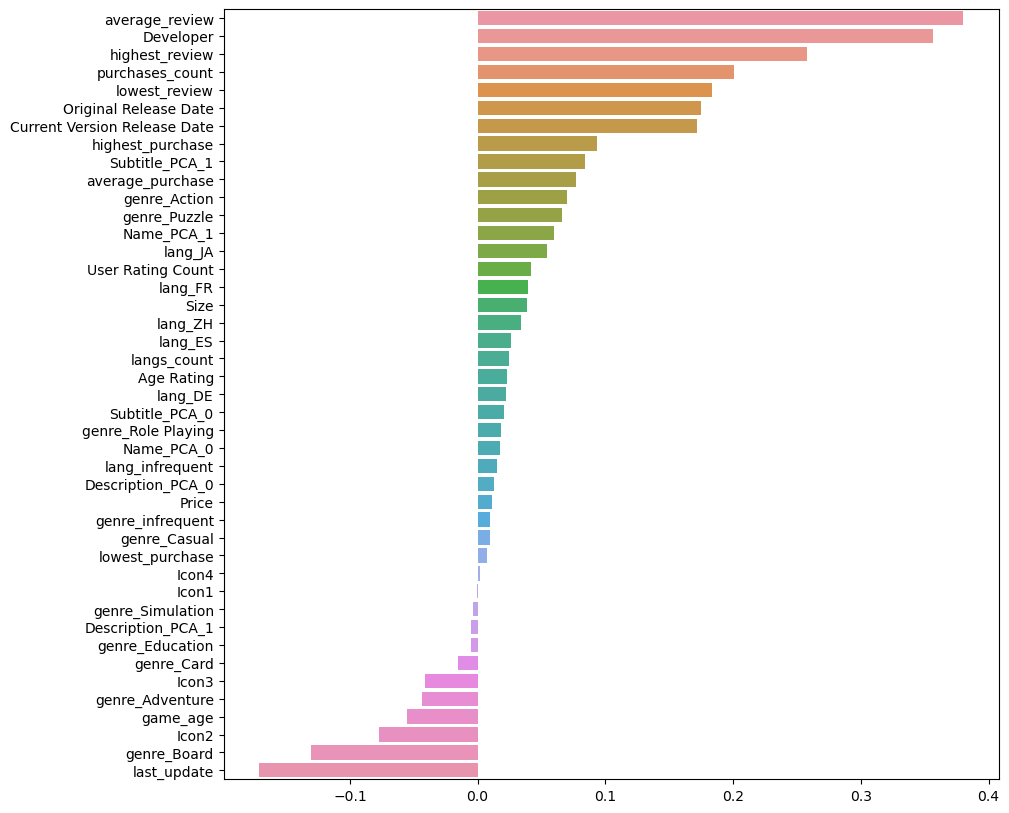

In [35]:
# plot correlation matrix between features and target
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_x.corrwith(df_y)
corr = corr.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.barplot(x=corr.values, y=corr.index)
plt.show()

### Feature Selection

In [36]:
# Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=10)
df_x_select =  selector.fit_transform(df_x, df_y)

# Save the selector
pickle.dump(selector, open('encoders/selector.pkl', 'wb'))

In [37]:
# Print the selected features
for i in range(len(selector.get_support())): 
    if selector.get_support()[i]:
        print(df_x.columns[i])

Developer
Original Release Date
Current Version Release Date
lowest_review
highest_review
average_review
last_update
genre_Board
purchases_count
highest_purchase


### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures


In [ ]:
# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/LR_model.pkl', 'wb'))


### Ridge Regression

In [ ]:
# Create a ridge regression model
model = Ridge(alpha=20)

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/Ridge_model.pkl', 'wb'))


### Lasso Regression

In [ ]:
# Create a lasso regression model
model = Lasso(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/Lasso_model.pkl', 'wb'))


### Elastic Net Regression

In [ ]:
# Create an elastic net regression model
model = ElasticNet(alpha=0.001)

# Train the model
model.fit(df_x_select, df_y)

# Save the model
pickle.dump(model, open('models/ElasticNet_model.pkl', 'wb'))


### Polynomial Regression

In [ ]:
# Create a polynomial regression model
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(df_x_select)

# Save the polynomial features
pickle.dump(poly, open('encoders/poly.pkl', 'wb'))

# Train the model
model = LinearRegression()
model.fit(X_train_poly, df_y)

# Save the model
pickle.dump(model, open('models/Polynomial_model.pkl', 'wb'))
